In [510]:

import gzip, shutil
import os 
import data_utils as du 
import tensorflow as tf 
from tensorflow import keras 
import numpy as np 
from six.moves import cPickle as pickle
import numpy as np
import os
from matplotlib.pyplot import imread
import matplotlib.pyplot as plt 
import platform
import data_utils as du 
from cnn_model import *
from solver import Solver
%load_ext autoreload
%autoreload 2
%matplotlib inline
%reload_ext autoreload
plt.rcParams['figure.figsize'] = (15.0, 15.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

Data_folder = 'CIFAR10_Data'
Data_fn = 'cifar-10-python'
X_train, y_train, X_val, y_val, X_test, y_test = du.get_CIFAR10_data(subtract_mean =True)
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape, y_train.dtype)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,) int64
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


In [511]:
import qunatize_resnet20 as q_res
import quantize_layers as ql
data_set = {
    'train_data': X_train,
    'train_label': y_train,
    'val_data':X_val,
    'val_label':y_val,
}
train_options = {
    'optimizer': 'adam',
    'lr': 0.001,
    'epoch_num': 20,
    'from_logits':True,
    'save_dir': 'resnet20_model'
}
qunatizer = ql.ModelQunatize() 
q_res20_model = q_res.Resnet20(quantizer=qunatizer)

solver = Solver(q_res20_model,data_set,train_options,save_model=True)
#solver.train()

In [512]:
solver.test_model(X_test,y_test)

Loss: 2319.7626953125,Test Accuracy: 10.0


(<tf.Tensor: shape=(), dtype=float32, numpy=2319.7627>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.1>)

## Show layers and quantizable layers 

In [513]:
import tensorflow_hub as hub 
import quantize_util as qu 
#prepare quntize model model_q
qunatizer = ql.ModelQunatize()
model_path = 'resnet20_model/trained_15'
full_model = hub.KerasLayer(model_path,trainable=True)
model_q = q_res.Resnet20(qunatizer)
qu.copy_weight(model_q,full_model)

train_options = {
    'optimizer': 'adam',
    'lr': 0.001,
    'epoch_num': 20,
    'from_logits':True,
    'save_dir': 'resnet20_model'
}
solver = Solver(model_q,data_set,train_options,save_model=True)




In [514]:
solver = Solver(model_q,data_set,train_options,save_model=True)
q_layer_num = model_q.get_quantizable_layer_count() 
wlfl_list = [[12,4]]*20
qunatizer.set_wlfl_list(wlfl_list)
qunatizer.set_full_precision_mode()
print('Accuracy in full precision mode:')
solver.test_model(X_test,y_test)

print('Accuracy in wlfl mode:')
qunatizer.set_quantize_mode()
solver.test_model(X_test,y_test)
qunatizer.set_full_precision_mode()



Accuracy in full precision mode:
Loss: 0.9363390803337097,Test Accuracy: 69.91000366210938
Accuracy in wlfl mode:
Loss: 0.9290823936462402,Test Accuracy: 69.41000366210938


### Test on quantize_var function 

In [515]:
qunatizer.set_wlfl_list(wlfl_list)
qunatizer.set_full_precision_mode()
print('Accuracy in full precision mode:')
solver.test_model(X_test,y_test)

print('Accuracy in wlfl mode:')
qunatizer.set_quantize_mode()
solver.test_model(X_test,y_test)
qunatizer.set_full_precision_mode()

Accuracy in full precision mode:
Loss: 0.9363390803337097,Test Accuracy: 69.91000366210938
Accuracy in wlfl mode:
Loss: 0.9290823936462402,Test Accuracy: 69.41000366210938


In [516]:
q_layers = model_q.get_quantizable_layers()
for layer in q_layers:
    #print(layer[0].kernel)
    print(layer)
a = np.abs(q_layers[0].kernel.numpy())
#print(a.reshape(-1))
c = a.reshape(-1).shape[0]
print(q_layers[0].kernel)



<tf.Variable 'quantize_conv2d_1045/kernel:0' shape=(3, 3, 3, 16) dtype=float32, numpy=
array([[[[-0.03953034,  0.03212732,  0.08058076,  0.4360998 ,
          -0.30798113,  0.2512633 , -0.0421763 , -0.31119138,
           0.02009004, -0.45123833, -0.03129359,  0.07896178,
           0.2638417 ,  0.02292283, -0.3471505 ,  0.2231442 ],
         [-0.23919603, -0.16176899,  0.01135234, -0.5045306 ,
           0.40276515, -0.01827848,  0.39766827,  0.00594939,
          -0.31354573,  0.03473083,  0.10555962, -0.42407283,
           0.02052283,  0.20112282, -0.20537013, -0.0101853 ],
         [ 0.36311188,  0.12317844, -0.12353028, -0.02495158,
           0.07731401, -0.1289679 , -0.14443053, -0.17462917,
           0.19985898,  0.08818743, -0.17899266,  0.02763722,
           0.06076494,  0.02174114, -0.15519632,  0.16838706]],

        [[-0.2652395 ,  0.1045576 ,  0.00411738,  0.16422231,
           0.18506159, -0.27059457, -0.02821511, -0.01449516,
           0.04443414, -0.20928118, -0.0

## Test WLsearch agent 

#### Test get_parameter_size 


In [517]:
import quantize_complier as qc 
q_layers = model_q.get_quantizable_layers()
wl_agent = qc.WLSearchAgent(model_q,full_model,q_layers)
total_size = wl_agent.get_parameter_size()
total_size = total_size
print('Total trainable parameter: {}'.format(total_size))
q_layers_copy = q_layers
q_data = q_layers[0].kernel 

#print(q_layers[0].kernel)
print('=============================')
#print(q_data)
print(len(wl_agent.layers_param_list))
print(wl_agent.wl_list.layer(15).kernel_wl)
wl_agent.get_intger_bits(-3)



Total trainable parameter: (268346, <quantize_complier.ParamSizeList object at 0x7fda10e1ec10>)
20
32


4

### Test init_search and compression_rate

In [518]:
wl_agent.init_search()
print(wl_agent.wl_list)
wl_agent.get_compression_rate()
print(wl_agent.parameter_size_list)

<quantize_complier.WlflList object at 0x7fda598d2400>[[8,16,0,16][8,16,0,16][8,16,0,16][8,16,0,16][8,16,0,16][8,16,0,16][8,16,0,16][8,16,0,16][8,16,0,16][8,16,0,16][8,16,0,16][8,16,0,16][8,16,0,16][8,16,0,16][8,16,0,16][8,16,0,16][8,16,0,16][8,16,0,16][8,16,0,16][8,16,8,16]]
<quantize_complier.ParamSizeList object at 0x7fda10e1e9a0>[[432,0][2304,0][2304,0][2304,0][2304,0][2304,0][2304,0][4608,0][9216,0][9216,0][9216,0][9216,0][9216,0][18432,0][36864,0][36864,0][36864,0][36864,0][36864,0][640,10]]


## Test SerachFL agent 

### Test search_layer_fl

In [519]:
#q_layers = wl_agent.get_quantize_layers()

data_set = {
    'train_data': X_train,
    'train_label': y_train,
    'val_data':X_val,
    'val_label':y_val,
}
train_options = {
    'optimizer': 'adam',
    'lr': 0.001,
    'epoch_num': 20,
    'from_logits':True,
    'save_dir': 'resnet20_model',
    
}
def acc_fn(model):
    solver = Solver(model_q,data_set,save_model=False,verbose=False)
    return solver.test_model(X_test,y_test)
    
fl_agent = qc.FlSerachAgent(model_q,solver,acc_fn)
print(len(wl_agent.get_wl_list()))
print(len(q_layers))
fl_agent.search_layers_fl(q_layers,wl_agent.get_wl_list())
print(wl_agent.get_wl_list())
fl_agent.apply_wlfl_to_layers(q_layers,wl_agent.get_wl_list())
fl_agent.model_accuracy()
print('restore full precision weight')
wl_agent.restore_model_weight()
fl_agent.model_accuracy()
print('Manual set wlfl')
wl_agent.get_wl_list().set_all_to(8,4)
print(wl_agent.get_wl_list())
fl_agent.apply_wlfl_to_layers(q_layers,wl_agent.get_wl_list())
fl_agent.model_accuracy()
print('restore weight')
wl_agent.restore_model_weight() 
print(wl_agent.get_wl_list())
fl_agent.model_accuracy()
print('research')
fl_agent.search_layers_fl(q_layers,wl_agent.get_wl_list())
print(wl_agent.get_wl_list())
fl_agent.apply_wlfl_to_layers(q_layers,wl_agent.get_wl_list())
fl_agent.model_accuracy()
wl_agent.get_compression_rate()


20
20
<quantize_complier.WlflList object at 0x7fda598d2400>[[8,7,0,0][8,8,0,0][8,8,0,0][8,8,0,0][8,8,0,0][8,8,0,0][8,8,0,0][8,8,0,0][8,8,0,0][8,8,0,0][8,8,0,0][8,8,0,0][8,8,0,0][8,8,0,0][8,8,0,0][8,8,0,0][8,8,0,0][8,8,0,0][8,8,0,0][8,8,8,7]]
restore full precision weight
Manual set wlfl
<quantize_complier.WlflList object at 0x7fda598d2400>[[8,4,8,4][8,4,8,4][8,4,8,4][8,4,8,4][8,4,8,4][8,4,8,4][8,4,8,4][8,4,8,4][8,4,8,4][8,4,8,4][8,4,8,4][8,4,8,4][8,4,8,4][8,4,8,4][8,4,8,4][8,4,8,4][8,4,8,4][8,4,8,4][8,4,8,4][8,4,8,4]]
restore weight
<quantize_complier.WlflList object at 0x7fda598d2400>[[8,4,8,4][8,4,8,4][8,4,8,4][8,4,8,4][8,4,8,4][8,4,8,4][8,4,8,4][8,4,8,4][8,4,8,4][8,4,8,4][8,4,8,4][8,4,8,4][8,4,8,4][8,4,8,4][8,4,8,4][8,4,8,4][8,4,8,4][8,4,8,4][8,4,8,4][8,4,8,4]]
research
<quantize_complier.WlflList object at 0x7fda598d2400>[[8,7,8,0][8,8,8,0][8,8,8,0][8,8,8,0][8,8,8,0][8,8,8,0][8,8,8,0][8,8,8,0][8,8,8,0][8,8,8,0][8,8,8,0][8,8,8,0][8,8,8,0][8,8,8,0][8,8,8,0][8,8,8,0][8,8,8,0][8,8,8,0]

(0.25, 2146768)

### Test on update_accuracy_loss_per_bit_list


In [520]:
wl_agent.restore_model_weight()
print(fl_agent.model_accuracy())
wl_agent.init_search()
print("wlfl after Init search")
print(wl_agent.get_wl_list())
print("acc_loss per bit list")
print(wl_agent.accuracy_loss_per_bit_list)
print("update list ")
print("====================")
print(wl_agent.parameter_size_list.layer(0).kernel_size)
wl_agent.update_accuracy_loss_per_bit_list(fl_agent)
print(wl_agent.accuracy_loss_per_bit_list)
print(wl_agent.accuracy_loss_per_bit_list.get_smallest_apb())


tf.Tensor(0.6991, shape=(), dtype=float32)
wlfl after Init search
<quantize_complier.WlflList object at 0x7fda598d2400>[[8,7,0,0][8,8,0,0][8,8,0,0][8,8,0,0][8,8,0,0][8,8,0,0][8,8,0,0][8,8,0,0][8,8,0,0][8,8,0,0][8,8,0,0][8,8,0,0][8,8,0,0][8,8,0,0][8,8,0,0][8,8,0,0][8,8,0,0][8,8,0,0][8,8,0,0][8,8,8,7]]
acc_loss per bit list
<quantize_complier.AccuracyLossPerBitList object at 0x7fda10e1e940>[[None,None][None,None][None,None][None,None][None,None][None,None][None,None][None,None][None,None][None,None][None,None][None,None][None,None][None,None][None,None][None,None][None,None][None,None][None,None][None,None]]
update list 
432
<quantize_complier.AccuracyLossPerBitList object at 0x7fda10e1e940>[[-1.157323481493222e-06,None][8.681995922188435e-08,None][3.906380925400299e-07,None][2.60434006804644e-07,None][-8.679408836087532e-08,None][2.1702402364098816e-07,None][4.340997961094217e-08,None][4.557271893190773e-07,None][0.0,None][7.595453155317955e-08,None][3.255101788113279e-08,None][-6.51020

In [521]:
#wl_agent.restore_model_weight()
#ori_acc = fl_agent.model_accuracy()
#print('Original accuracy:{}'.format(ori_acc))
#wl_agent.init_search()
#print(wl_agent.get_wl_list())
#wl_agent.fine_search(fl_agent)

In [522]:
wl_agent.restore_model_weight()
wl_agent.wl_list.load('wlfl_list.txt')
print(wl_agent.wl_list)
wl_agent.restore_model_weight()

fl_agent.apply_wlfl_to_layers(wl_agent.quantize_layers,wl_agent.wl_list)
print('quantized_model acc: {}'.format(fl_agent.model_accuracy()))
wl_agent.restore_model_weight()
print('full precision model acc:')
solver.test_model(X_test,y_test)


<quantize_complier.WlflList object at 0x7fda598d2400>[[6,5,0,0][5,5,0,0][5,5,0,0][2,3,0,0][4,4,0,0][4,5,0,0][3,4,0,0][6,6,0,0][5,5,0,0][5,5,0,0][6,6,0,0][4,5,0,0][5,5,0,0][5,5,0,0][5,5,0,0][4,5,0,0][4,5,0,0][3,5,0,0][2,3,0,0][5,5,2,1]]
quantized_model acc: 0.6678000092506409
full precision model acc:
Loss: 0.9363390803337097,Test Accuracy: 69.91000366210938


(<tf.Tensor: shape=(), dtype=float32, numpy=0.9363391>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.6991>)

full model test acc: 0.6991000175476074
quantized model test acc: 0.6678000092506409
Epoch: 0/1
 313/312 |=========================|  - train_acc: 0.8205 - train_loss: 0.5003 - val_acc: 0.6940 - val_loss: 1.0169


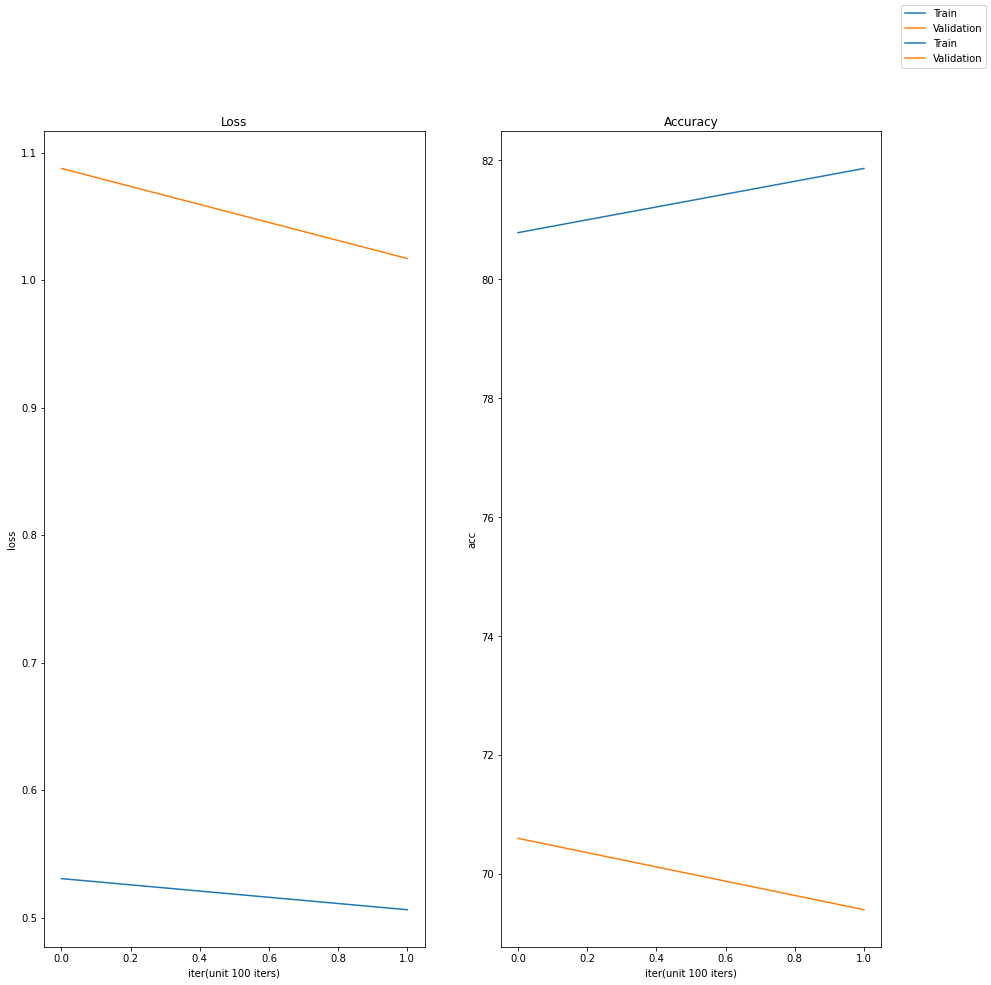

In [554]:
data_set = {
    'train_data': X_train[20000:30000],
    'train_label': y_train[20000:30000],
    'val_data':X_val,
    'val_label':y_val,
}
train_options = {
    'optimizer': 'adam',
    'lr': 0.001,
    'epoch_num': 1,
    'from_logits':True,
    'save_dir': 'resnet20_model',
}
wl_agent.restore_model_weight()
print('full model test acc: {}'.format(fl_agent.model_accuracy()))
wl_agent.wl_list.load('wlfl_list.txt')
fl_agent.apply_wlfl_to_layers(wl_agent.quantize_layers,wl_agent.wl_list)
print('quantized model test acc: {}'.format(fl_agent.model_accuracy()))
solver = Solver(model_q,data_set,options=train_options,save_model=False)
solver.train()


In [555]:

wl_agent.wl_list.load('wlfl_list.txt')
fl_agent.apply_wlfl_to_layers(wl_agent.quantize_layers,wl_agent.wl_list)
print('quantize model acc after retrain: {}'.format(fl_agent.model_accuracy()))
wl_agent.restore_model_weight()

fl_agent.apply_wlfl_to_layers(wl_agent.quantize_layers,wl_agent.wl_list)
print('qunatize_model acc before retrain:{}'.format(fl_agent.model_accuracy()))





quantize model acc after retrain: 0.6927000284194946
qunatize_model acc before retrain:0.6678000092506409
